In [1]:
import os
import sys
sys.path.append(os.getcwd())
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")) + '/lib/')
import time
import torch
import numpy as np
import random
import torch.nn as nn
import matplotlib.pyplot as plt
from torch_geometric.data import DataLoader
from torch_geometric.data import Data

from lib.net import GNN_Net
from lib.pytorchtools import EarlyStopping, check_gpu
from lib.identity_rate import identity_rate,dataset_summary

from lib.frameify_1f_S_baseline import build_1f_S_datasets 



/Users/xiemengtong/anaconda3/envs/Tac-VGNN/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
TIP_NUM = 331  # 你的数据就是 331

def _infer_T(d, tip_num=TIP_NUM):
    T = d.x.size(0) // tip_num
    assert T * tip_num == d.x.size(0), f"node数 {d.x.size(0)} 不是 T×{tip_num}"
    return T

# def identity_rate(d, tip_num=TIP_NUM):
#     """相邻帧‘身份一致率’（t帧第 i 个节点在 t+1 帧的最近邻是否仍是 i）。理想≥0.95"""
#     T = _infer_T(d, tip_num)
#     XY = d.x[:, :2].view(T, tip_num, 2)              # (T, N, 2)
#     ok = []
#     for t in range(T-1):
#         A, B = XY[t], XY[t+1]                         # (N,2)
#         dist = ((A[:,None]-B[None,:])**2).sum(-1).sqrt()  # (N,N)
#         ok.append((dist.argmin(1) == torch.arange(tip_num)).float().mean().item())
#     return float(np.mean(ok))

def strip_temporal_edges(d, tip_num=TIP_NUM):
    """去掉跨帧边（按你的构造：|u-v|==N 的边就是 temporal 边）"""
    ei = d.edge_index
    keep = (ei[0] - ei[1]).abs() != tip_num
    return Data(x=d.x.clone(), edge_index=ei[:, keep].clone(), y=d.y.clone())

def last_frame_subgraph(d, tip_num=TIP_NUM):
    """只取最后一帧，恢复成 baseline 的单帧图"""
    T = _infer_T(d, tip_num)
    i0, i1 = (T-1)*tip_num, T*tip_num
    ei = d.edge_index
    mask = (ei[0] >= i0) & (ei[0] < i1) & (ei[1] >= i0) & (ei[1] < i1)
    new_ei = (ei[:, mask] - i0).contiguous()
    return Data(x=d.x[i0:i1].clone(), edge_index=new_ei.clone(), y=d.y.clone())


def k_last_frames_subgraph(d, k=5, N=331):
    T = d.x.size(0)//N
    assert 1 <= k <= T
    i0, i1 = (T-k)*N, T*N
    ei = d.edge_index
    m = (ei[0]>=i0)&(ei[0]<i1)&(ei[1]>=i0)&(ei[1]<i1)
    from torch_geometric.data import Data
    return Data(x=d.x[i0:i1].clone(),
                edge_index=(ei[:,m]-i0).contiguous(),
                y=d.y.clone())

# def ensure_t(batch):
#     """老师代码用 batch.t，当你存的是 y 时，补一个别名即可"""
#     if not hasattr(batch, "t"):
#         batch.t = batch.y
#     return batch


## 1. Define Main Loop for GNN Training

In [3]:
def main(train_data_dir):

     # === 试验开关 ===
    VARIANT = "last_frame"          # 可选: "orig"（原始含temporal边）、"no_temporal"（去掉跨帧边）、"last_frame"（单帧baseline）
    CHECK_IDENTITY = True     # 计算并打印对齐率
    K_FRAMES = 5



    ####  1. Training Parameter Setting  ####

    LR = 0.0015  ## learning rate

    epoch_num = 200  ## epoch number

    batch_size = 2  ## batch size

    patience = 30  ## early_stopping patience

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  ## device defination

    model = GNN_Net().to(device)  ## GNN model loading

    optimizer = torch.optim.Adam(model.parameters(), lr=LR)  ## optimizer setting

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True,
                                                           threshold=0.001, threshold_mode='rel',
                                                           cooldown=0, min_lr=0, eps=1e-08)  ## learning rate adapter setting

    criterion = nn.L1Loss()  ## MAE Loss

    early_stopping = EarlyStopping(patience=patience, verbose=True)  ## initialize the early_stopping object

    history = {
        "train_loss": [],
        "train_time": [],
        "val_loss": [],
    }  ## training history recording


    ####  2. Dataset Loading  ####

    graph_list_dir = os.path.join(train_data_dir, 'Train_data_list.pt')  ## train/val set dir
    graph_list = torch.load(graph_list_dir)  ## load voronoi graph dataset
    

    gl = torch.load(graph_list_dir, map_location="cpu")  # 或你的绝对路径

    s = gl[0]
    def get(z,k):
        return (z[k] if hasattr(z,'keys') and k in z else getattr(z,k) if hasattr(z,k) else None)

    for k in ["x","edge_index","y","pos","edge_attr","temporal_edge_index"]:
        v = get(s,k)
        print(k, "->", (tuple(v.shape), v.dtype) if torch.is_tensor(v) else type(v))

    # dtype 提示
    if torch.is_tensor(get(s,"x")) and get(s,"x").dtype!=torch.float32: print("x -> float32 建议")
    if torch.is_tensor(get(s,"edge_index")) and get(s,"edge_index").dtype!=torch.long: print("edge_index -> int64 建议")

    

    
    np.random.shuffle(graph_list)  ## shuffle the dataset
    np.random.shuffle(graph_list)  ## shuffle the dataset

    train_size = int(len(graph_list) * 0.8)   ## train set size
    val_size = int(len(graph_list) * 0.2)   ## validation set size

    train_dataset = graph_list[:train_size]  
    val_dataset = graph_list[train_size:train_size + val_size] 
    
    print(f"[CHECK] total={len(graph_list)}  train={len(train_dataset)}  val={len(val_dataset)}")

    # —— 若没定义 TIP_NUM，就先设为 331（你数据峰值）——


    def _to_numpy(arr):
        import torch, numpy as np
        if torch.is_tensor(arr):
            return arr.detach().cpu().numpy()
        return np.asarray(arr)

    def my_get_num_frames(seq_item):
        """
        你的序列样本把 T 帧节点拼在一起（长度 = T * TIP_NUM）。
        用 x 的长度反推 T（更稳）。
        """
        import torch
        assert hasattr(seq_item, "x") and torch.is_tensor(seq_item.x), "seq_item.x 缺失或不是张量"
        total_nodes = int(seq_item.x.size(0))
        assert total_nodes % TIP_NUM == 0, f"x 节点数 {total_nodes} 不是 TIP_NUM={TIP_NUM} 的整数倍"
        return total_nodes // TIP_NUM

    def my_extractor(seq_item, t):
        """
        从“序列样本”中抽取第 t 帧，构建单帧 (pos, x, y)：
        - pos: (N,2) 纯空间坐标（优先用 data.pos；没有就用 data.x 的前两列）
        - x:   (N,F) 节点特征；若没有就用 pos 充当特征
        - y:   (2,) 该帧目标（训练尺度；评估前做 inverse_transform）
        """

        T = my_get_num_frames(seq_item)
        N = TIP_NUM
        assert 0 <= t < T, f"t={t} 超界（T={T}）"
        lo, hi = t * N, (t + 1) * N

        # 1) 取 pos：优先 data.pos；否则从 x 的前两列兜底
        pos_full = getattr(seq_item, "pos", None)
        if pos_full is None or (torch.is_tensor(pos_full) and pos_full.numel() == 0):
            # 用 x[:, :2] 作为坐标
            assert hasattr(seq_item, "x") and seq_item.x.size(1) >= 2, \
                "没有 pos，且 x 的列数 < 2，无法构建 Delaunay。请确认坐标存放位置。"
            pos_full = seq_item.x[:, :2]

        pos_t = pos_full[lo:hi]  # (N,2)

        # 2) 取 x 特征：如果有就切片；没有就设为 None（后续用 pos 代替）
        x_full = getattr(seq_item, "x", None)
        x_t = x_full[lo:hi] if (x_full is not None and torch.is_tensor(x_full)) else None

        # 3) 逐帧标签 y_t：兼容多种存储方式
        y_t = None
        if hasattr(seq_item, "y") and torch.is_tensor(seq_item.y):
            y = seq_item.y
            if y.dim() == 2 and y.size(0) == T:        # [T,2]
                y_t = y[t]
            elif y.dim() == 1 and y.numel() == 2:      # 只有一个 [2]，退化为整段同一标签（不建议，但先兜底）
                y_t = y
            elif y.numel() == T * 2:
                y_t = y.view(T, 2)[t]
        if y_t is None and hasattr(seq_item, "labels"):
            lab = seq_item.labels
            lab = lab if torch.is_tensor(lab) else torch.as_tensor(lab)
            if lab.dim() == 2 and lab.size(0) == T:
                y_t = lab[t]
        if y_t is None and hasattr(seq_item, "y_all"):
            ya = seq_item.y_all
            ya = ya if torch.is_tensor(ya) else torch.as_tensor(ya)
            if ya.dim() == 2 and ya.size(0) == T:
                y_t = ya[t]

        if y_t is None:
            raise ValueError("找不到逐帧标签 y_t。请确认 Data.y / Data.labels / Data.y_all 是否存 [T,2]。")

        # 4) 转 numpy，交给构建器
        pos_xy_np = _to_numpy(pos_t)                # (N,2)
        x_node_np = None if x_t is None else _to_numpy(x_t)  # (N,F) or None
        y_label_np = _to_numpy(y_t)                # (2,)
        return pos_xy_np, x_node_np, y_label_np


  


    
    
    # === 用 K_FRAMES 裁剪，并按 VARIANT 决定是否去时序边 ===
    if VARIANT == "orig":              # ST：保留时序边
        train_dataset_run = [k_last_frames_subgraph(d, K_FRAMES, TIP_NUM) for d in train_dataset]
        val_dataset_run   = [k_last_frames_subgraph(d, K_FRAMES, TIP_NUM) for d in val_dataset]
        print(f"[Variant] RUN = GCN-{K_FRAMES}f-ST")
      

    elif VARIANT == "no_temporal":     # S：去掉时序边
        train_dataset_run = [strip_temporal_edges(k_last_frames_subgraph(d, K_FRAMES, TIP_NUM), TIP_NUM) for d in train_dataset]
        val_dataset_run   = [strip_temporal_edges(k_last_frames_subgraph(d, K_FRAMES, TIP_NUM), TIP_NUM) for d in val_dataset]
        print(f"[Variant] RUN = GCN-{K_FRAMES}f-S")
    # elif VARIANT == "last_frame":      # 单帧基线
    #     train_dataset_run = [last_frame_subgraph(d, TIP_NUM) for d in train_dataset]
    #     val_dataset_run   = [last_frame_subgraph(d, TIP_NUM) for d in val_dataset]
    #     print(f"[Variant] RUN = GCN-1f-S (last frame)")
    elif VARIANT == "last_frame":  # 单帧基线（逐帧展开，纯空间图）
        train_dataset_run, val_dataset_run = build_1f_S_datasets(
            train_dataset,             # 注意：用你刚分完的“序列级”列表
            val_dataset,
            get_num_frames=my_get_num_frames,
            extractor=my_extractor,
            tip_num=None,              # 对齐老师，先关闭筛点
            add_self_loops=True,
            make_undirected=True,
            require_delaunay=True,     # 没装 scipy 也会自动 fallback
        )
        print("[Variant] RUN = GCN-1f-S (frameify-all-frames, spatial-only)")
    else:
        raise ValueError(f"Unknown VARIANT={VARIANT}")
    
    if VARIANT in ("orig", "no_temporal"):
        s = train_dataset_run[0]
        T_after = s.x.size(0) // TIP_NUM
        print(f"[AFTER CROP] x={tuple(s.x.shape)}  edge_index={tuple(s.edge_index.shape)}  T={T_after}")
        mask = (s.edge_index[0] - s.edge_index[1]).abs() == TIP_NUM
        print(f"[AFTER CROP] temporal edges kept: {int(mask.sum())} / {(T_after-1)*TIP_NUM}")



    # # —— Sanity check: K 生效与否 ——
    # s = train_dataset_run[0]
    # T_after = s.x.size(0) // TIP_NUM
    # print(f"[AFTER CROP] x={tuple(s.x.shape)}  edge_index={tuple(s.edge_index.shape)}  T={T_after}")
    # # 统计本样本保留下来的时序边比例（S 模式会是 0）
    # mask = (s.edge_index[0] - s.edge_index[1]).abs() == TIP_NUM
    # print(f"[AFTER CROP] temporal edges kept: {int(mask.sum())} / {(T_after-1)*TIP_NUM}")


    
    if CHECK_IDENTITY:
        pool = train_dataset_run
        idx = random.sample(range(len(pool)), k=min(20, len(pool)))
        rates = [identity_rate(pool[i], TIP_NUM) for i in idx]
        # print(f"[IdentityRate] mean={np.mean(rates):.3f}, min={np.min(rates):.3f}, max={np.max(rates):.3f}")
        # …完成了 K_FRAMES 裁剪 + 过滤 + VARIANT 处理…
        # 现在 train_dataset_run / val_dataset_run 已经就绪

        dataset_summary(train_dataset_run, N=TIP_NUM, name="train(run)", use_hungarian=True)
        dataset_summary(val_dataset_run,   N=TIP_NUM, name="val(run)",   use_hungarian=True)

        # print_dataset_temporal_summary(train_dataset_run, N=TIP_NUM, name="train(run)")
        # print_dataset_temporal_summary(val_dataset_run,   N=TIP_NUM, name="val(run)")

    # === 时序边体检（建议按“当前 run”的数据统计）===
    def temporal_stats(d, N=331):
        T = d.x.size(0)//N
        ei = d.edge_index
        temp_mask = (ei[0]-ei[1]).abs()==N
        kept = int(temp_mask.sum().item())
        max_possible = (T-1)*N
        kept_frac = kept / max_possible if max_possible>0 else 0.0
        total = int(ei.size(1))
        total_ratio = kept / total if total>0 else 0.0
        
        return T, kept, max_possible, kept_frac, total_ratio

    # 选择用于统计的样本池：
    # - ST: 直接用 train_dataset_run（裁到 K 帧且保留了时序边）
    # - S : 由于 train_dataset_run 的时序边被去掉了，为了看“本该能保留多少”，
    #      用“仅裁剪、不去边”的版本来统计
    # if VARIANT == "no_temporal":
    #     stats_pool = [k_last_frames_subgraph(d, K_FRAMES, TIP_NUM) for d in train_dataset]
    # else:
    #     stats_pool = train_dataset_run

    # if VARIANT in ("orig", "no_temporal"):
    #     stats_pool = [k_last_frames_subgraph(d, K_FRAMES, TIP_NUM) for d
    # else:
    
    print(f"[INFO] 1f baseline: per-frame samples ready: train={len(train_dataset_run)}  val={len(val_dataset_run)}")



    # idx = random.sample(range(len(stats_pool)), k=min(10, len(stats_pool)))
    # T_list, kept_frac_list, total_ratio_list, idr_list = [], [], [], []
    # for i in idx:
    #     d = stats_pool[i]
    #     T, kept, maxp, kept_frac, total_ratio = temporal_stats(d, TIP_NUM)
    #     T_list.append(T); kept_frac_list.append(kept_frac); total_ratio_list.append(total_ratio)
    #     idr_list.append(identity_rate(d, TIP_NUM))
    #     print(f"[Sample {i}] T={T}  kept={kept}/{maxp}  kept_frac={kept_frac:.2f}  "
    #         f"temp/edges={total_ratio:.2%}  IdentityRate={idr_list[-1]:.3f}")

    # print(f"[SUMMARY] T≈{np.mean(T_list):.1f}  kept_frac(mean)={np.mean(kept_frac_list):.2f}  "
    #     f"temp/edges(mean)={np.mean(total_ratio_list):.2%}  IdentityRate(mean)={np.mean(idr_list):.3f}")



    # === 建 DataLoader（训练: drop_last=True 防止 BN 遇到 batch=1）===

    train_loader = DataLoader(train_dataset_run, batch_size=batch_size, shuffle=True,  drop_last=True)
    val_loader   = DataLoader(val_dataset_run,   batch_size=batch_size,   shuffle=False, drop_last=False)
    print(f"[CHECK] train={len(train_dataset_run)} val={len(val_dataset_run)} "
          f"| train_batches={len(train_loader)} val_batches={len(val_loader)}")

    
    # trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, drop_last=True)  ## training dataset
    # validloader = DataLoader(valset, batch_size=batch_size, shuffle=False, drop_last=False)  ## validation dataset
    # print(f"[CHECK] batch_size={batch_size}  train_batches={len(trainloader)}  val_batches={len(validloader)}")

    ####  3. Start Training   ####
    
    print('Start Train')
    
    erro = 10000  ## initialise error value to max
    pose_2_norm = 1  ## pose_2 norm scale
    pose_6_norm = 1  ## pose_6 norm scale

    for epoch in range(epoch_num):  ## start an epoch...
        
        start = time.time()
        train_loss = 0.0
        train_total = 0
        train_batch_num = 0.0

        ## Train loop
        for i, batch in enumerate(train_loader):  ## start a batch...

            model.train()  ## set as traning mode
            
            batch = batch.to(device)  ## load batch data

            optimizer.zero_grad()  ## gradiant clear

            outputs = model(batch)  ## GNN model prediction output

            out_norm = outputs*torch.tensor([pose_2_norm,pose_6_norm]).to(device) ## output normalization

            label_norm = (batch.y).view(outputs.size())*torch.tensor([pose_2_norm,pose_6_norm]).to(device)  ## target normalization

            loss = criterion(out_norm, label_norm)  ## calculate loss    

            loss.backward()  ## backward

            optimizer.step()  ## parameter update bt optimizer

            train_loss += loss.cpu().item()  ## Loss add

            train_total += 1  ## update train times 

            train_batch_num += 1  ## update batch number 

            if i % 10 == 9:
                progress_bar = '[' + ('=' * ((i + 1) // 10)) + (' ' * ((train_size // 100 - (i + 1)) // 10)) + ']'
                print('\repoch: {:d} training loss: {:.5f} {}'
                      .format(epoch + 1, loss.cpu().item(), progress_bar), end="  ")  ## live Loss

        time_cost = time.time() - start
        # 训练循环结束后，计算平均
        avg_train_loss = train_loss / max(1, train_batch_num)
        print('\repoch: {:d} train loss: {:.5f} training time: {:.1f} s/epoch'
            .format(epoch + 1, avg_train_，loss, time_cost), end="  ")
        history["train_loss"].append(avg_train_loss)

        # print('\repoch: {:d} train loss: {:.5f} training time: {:.1f} s/epoch'
        #       .format(epoch + 1, train_loss / (train_size / batch_size), time_cost), end="  ")  # current epoch avrage Loss of each batch
        

        # history["train_loss"].append(train_loss / (train_size / batch_size))  ## record train loss
        history["train_time"].append(time_cost)   ## record train time cost


        ####  4. Start Validation  ####

        model.eval()  ## set as evaluation mode, to make traning smoother and faster, may just note and ignore it

        val_batch_num = 0
        val_loss = 0
        
        ## Validation loop
        with torch.no_grad():  ## stop gradiant update

            for data in val_loader: 

                data = data.to(device)  ## load batch data

                outputs = model(data)  ## GNN model prediction output

                out_norm = outputs*torch.tensor([pose_2_norm, pose_6_norm]).to(device)

                label_norm = (data.y).view(outputs.size())*torch.tensor([pose_2_norm,pose_6_norm]).to(device)

                val_loss += criterion(out_norm, label_norm)  ## Valid Loss

                val_batch_num += 1

               


        history["val_loss"].append(float(val_loss / val_batch_num))  ## record val loss

        print(f'Valid Loss: {val_loss / val_batch_num:.5f}', end='  ')  ## val loss

        # scheduler.step(loss.cpu().item() / val_batch_num)  # learning rate update
        scheduler.step(val_loss / val_batch_num)


        LR_ = optimizer.param_groups[0]['lr']  ## new learning rate

        print('\n' + f'learning rate: {LR_:.8f}', end='  ')  

        if (val_loss / val_batch_num) < erro:  ## save the best model from all epoch

            erro = val_loss / val_batch_num

            model_dir = train_data_dir + '/best_model.pth'

            torch.save(model.state_dict(), model_dir)   

            print('\n' + 'Saving model......' + '\n')
            
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(val_loss, model)
        
        if early_stopping.early_stop:
            print('\n' + 'Early stopping')
            break

    # load the last checkpoint with the best model
    # model.load_state_dict(torch.load('checkpoint.pt'))
    
    print('\n' + 'Finished Training')
    

    ####  5. Save Training Results  ####
    
    ## visualize the loss as the network trained
    fig = plt.figure(figsize=(10,8))
    plt.plot(range(1,len(history["train_loss"])+1),history["train_loss"], label='Training Loss')
    plt.plot(range(1,len(history["val_loss"])+1),history["val_loss"],label='Validation Loss')
    
    ## find position of lowest validation loss
    minposs = history["val_loss"].index(min(history["val_loss"]))+1 
    plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')
    
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0, history["train_loss"][0]*1.2) # consistent scale
    plt.xlim(0, len(history["train_loss"])+1) # consistent scale
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


    
    ## save the loss plot
    fig.savefig(train_data_dir + '/loss_plot' + '.png', bbox_inches='tight')

     # === 评估 MAE (Y / θ) ===

    def eval_mae(loader):
        model.eval()
        sum_y = sum_th = n = 0
        with torch.no_grad():
            for batch in loader:
                batch = batch.to(device)              #  移到 device
                out = model(batch)
                tgt = batch.y.view(out.size()).to(device)  # 用 y（或先 ensure_t 再用 t）
                err = (out - tgt).abs()
                sum_y  += float(err[:,0].sum().cpu())
                sum_th += float(err[:,1].sum().cpu())
                n      += err.size(0)
        return (sum_y/max(1,n), sum_th/max(1,n))
        



    mae_y_tr, mae_th_tr = eval_mae(train_loader)
    mae_y_va, mae_th_va = eval_mae(val_loader)
    print(f"\n[MAE] Train: Y={mae_y_tr:.4f} mm | θ={mae_th_tr:.4f} °")
    print(f"[MAE] Valid: Y={mae_y_va:.4f} mm | θ={mae_th_va:.4f} °")

## 2. Run Main Loop for GNN Training

x -> ((6620, 3), torch.float32)
edge_index -> ((2, 42698), torch.int64)
y -> ((2,), torch.float32)
pos -> <class 'NoneType'>
edge_attr -> <class 'NoneType'>
temporal_edge_index -> ((2, 5498), torch.int64)
[CHECK] total=108  train=86  val=21
[Variant] RUN = GCN-1f-S (frameify-all-frames, spatial-only)
[Variant] RUN = GCN-1f-S (frameify-all-frames, spatial-only)
[train(run)] GIR-E (geom_over_edges) mean/min/max = 0.000 / 0.000 / 0.000
[train(run)] ICR-NN (nn_over_frames) mean/min/max = 0.000 / 0.000 / 0.000
[train(run)] E-ICR (edge_index)       mean/min/max = 0.000 / 0.000 / 0.000
[train(run)] kept_frac(mean) = 0.000
[val(run)] GIR-E (geom_over_edges) mean/min/max = 0.000 / 0.000 / 0.000
[val(run)] ICR-NN (nn_over_frames) mean/min/max = 0.000 / 0.000 / 0.000
[val(run)] E-ICR (edge_index)       mean/min/max = 0.000 / 0.000 / 0.000
[val(run)] kept_frac(mean) = 0.000
[INFO] 1f baseline: per-frame samples ready: train=1720  val=420
[CHECK] train=1720 val=420 | train_batches=860 val_batches=2

/Users/xiemengtong/anaconda3/envs/Tac-VGNN/lib/python3.8/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


epoch: 1 train loss: 3.70227 training time: 13.1 s/epoch  Valid Loss: 4.15002  
learning rate: 0.00150000  
Saving model......

Validation loss decreased (inf --> 871.504517).  Saving model ...
epoch: 2 train loss: 3.75266 training time: 12.3 s/epoch  Valid Loss: 4.73444  
learning rate: 0.00150000  EarlyStopping counter: 1 out of 30

epoch: 3 train loss: 3.71371 training time: 18.4 s/epoch  Valid Loss: 4.22015  
learning rate: 0.00150000  EarlyStopping counter: 2 out of 30

epoch: 4 train loss: 3.56046 training time: 13.6 s/epoch  Valid Loss: 4.27690  
learning rate: 0.00150000  EarlyStopping counter: 3 out of 30

epoch: 5 train loss: 3.49538 training time: 15.5 s/epoch  Valid Loss: 4.37011  Epoch 00005: reducing learning rate of group 0 to 7.5000e-04.

learning rate: 0.00075000  EarlyStopping counter: 4 out of 30

epoch: 6 train loss: 3.54614 training time: 13.9 s/epoch  Valid Loss: 4.16394  
learning rate: 0.00075000  EarlyStopping counter: 5 out of 30

epoch: 7 train loss: 3.52476 

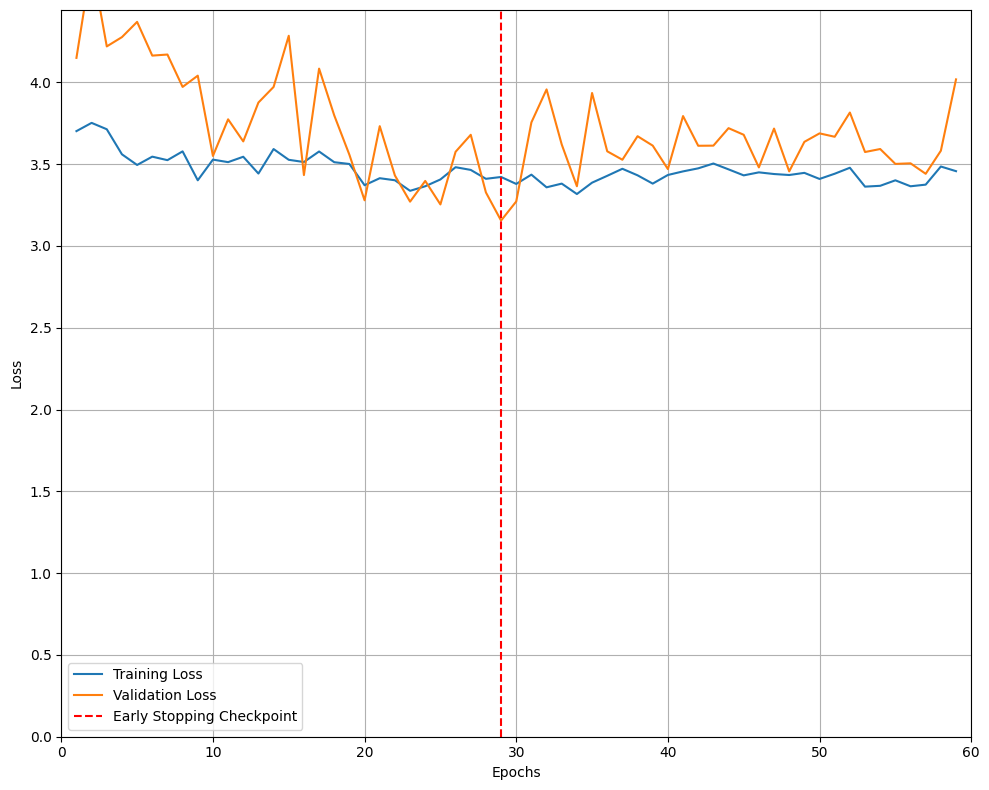


[MAE] Train: Y=1.2154 mm | θ=5.1349 °
[MAE] Valid: Y=1.1432 mm | θ=6.8940 °


In [4]:
train_data_dir = r'../result/train'  ## train data dir

#check_gpu(0)  ## set gpu device id

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"  ## allow duplicate load DLL

if __name__ == "__main__":
    
    main(train_data_dir)